
# Analyze energy consumption in buildings

This Python notebook shows you how to use analytics to determine the factors that contibute to energy inefficiency in buildings and to help develop strategies to reduce energy consumption and greenhouse gas emissions. 


You can learn more about statistical modeling and optimization methods that can be used to optimize energy consumption in buildings in [this article](http://www.informs-sim.org/wsc11papers/082.pdf). The article was written by a group of researchers from the following institutions: 
-  IBM T.J. Watson Research Center 
-  CUNY Institute for Urban Systems
-  McMaster University. 


## Table of contents

- [Get data](#get_data)
- [Load data](#load_data)
- [Access data](#access_data)
- [Load libraries](#load_libraries)
- [Model energy usage of buildings in kWh](#Model-energy-usage-in-kWh-of-buildings)
  - [Prepare the data](#data_preparation)
  - [Fit a linear regression model to the observed data](#linear_regression)
  - [Visualize model accuracy](#visualize_model_accuracy)
- [Detect buildings that consume energy inefficiently](#buildings_inefficient)
  - [Consider all metrics when measuring energy inefficiencies](#consider_all_metrics)
- [Export data and models to RStudio](#Export-data-and-models-to-RStudio)
- [Summary](#summary)



<a id="get_data"></a>
## Get data

The notebook uses data sets created by BlocPower, a startup based in New York, which supports clean energy projects in the city. The data sets contain information on property names, property sizes, and their respective energy usage in kWh. By using  different metrics, such as plug-load consumption, air conditioning consumption, and usage of domestic gas and heating gas, you will learn how to use analytics to identify buildings that consume energy inefficiently.

To get the energy comsumption data sets:

1. Go to the [BlocPower data sets](https://github.com/IBMDataScience/SparkSummitDemo/tree/master/data) and then download the following data sets in CSV format:
    * BlocPower_T.csv
    * HDD-Features.csv
    * CDD-HDD-Features.csv 
2. Save the CSV files to your computer.

<a id="load_data"></a>
## Load data 

After you have saved the files to your local file system, load the data files to use in the notebook:

1. In your project, click the assets icon.
2. Scroll to **Data Sets**, select **Add data set**, and drag and drop (or browse for) the following CSV files:
    * BlocPower_T.csv
    * HDD-Features.csv
    * CDD-HDD-Features.csv   

The data files are listed on the `Data Sets` pane and are stored in the filesystem.

<a id="access_data"></a>
## Access data
Before you can access data in data files in object storage by using the [SparkContext](https://spark.apache.org/docs/1.6.0/api/python/pyspark.html#pyspark.SparkContext) object, you must set the Hadoop configuration.

To add the code to access the data files in object storage and set the Hadoop configuration, click the next code cell and select **Insert to code>Spark SQL DataFrame** for each data file in the **Data** pane that you loaded.

This function inserts the setup code for the preconfigured `SparkContext`. Then the data is loaded into a `Spark DataFrame in Python`, which is created by using `SparkContext`. The credentials for accessing the CSV file are included in the generated code. 

When you repeat this action on the second and third data files, only the data is loaded into a `Spark SQL DataFrame`; the setup code does not have to run again. 


Note: The `Spark SQL DataFrames` that are created and loaded with data for you are given generic names. Give the DataFrame variables the following names:

- `df2` for the BlocPower_t.csv file
- `dfHDD` for the HDD-Features.csv file
- `dfCH` for the CDD-HDD-Features.csv file

Then, run each code cell to proceed.

In [1]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# Add asset from file system
df2 = sqlContext.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true')\
    .csv('../datasets/BlocPower_T.csv')
df2.take(5)

[Row(UTSUM_Electricity_Usage=u'117,870 kWh', INFO_Year of Construction=u'1955', INFO_Number of Stories=4, INFO_Total Square Feet=u'14,600', PLEI_1_Quantity=1, PLEI_3_Quantity=u'2'),
 Row(UTSUM_Electricity_Usage=u'16,207 kWh', INFO_Year of Construction=u'1940', INFO_Number of Stories=1, INFO_Total Square Feet=u'600', PLEI_1_Quantity=1, PLEI_3_Quantity=None),
 Row(UTSUM_Electricity_Usage=u'15,564 kWh', INFO_Year of Construction=u'1920', INFO_Number of Stories=2, INFO_Total Square Feet=u'6,000', PLEI_1_Quantity=2, PLEI_3_Quantity=u'1'),
 Row(UTSUM_Electricity_Usage=u'25,851 kWh', INFO_Year of Construction=u'1965', INFO_Number of Stories=1, INFO_Total Square Feet=u'5,000', PLEI_1_Quantity=6, PLEI_3_Quantity=u'1'),
 Row(UTSUM_Electricity_Usage=u'32,343 kWh', INFO_Year of Construction=u'1930', INFO_Number of Stories=3, INFO_Total Square Feet=u'4,196', PLEI_1_Quantity=1, PLEI_3_Quantity=u'1')]

In [2]:
dfHDD = sqlContext.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true')\
    .csv('../datasets/HDD-Features.csv')
dfHDD.take(5)

[Row(domestic_gas=0.096226455, heating_gas=0.366193236),
 Row(domestic_gas=0.322599638, heating_gas=0.57959223),
 Row(domestic_gas=0.032705972, heating_gas=0.036460695),
 Row(domestic_gas=0.02750427, heating_gas=0.23466382),
 Row(domestic_gas=0.322599638, heating_gas=0.57959223)]

In [3]:
dfCH = sqlContext.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true')\
    .csv('../datasets/CDD-HDD-Features.csv')
dfCH.take(5)

[Row(Property Name=u'ChurchofStCeciliaReport', plug_load_consumption=11.65140596, ac_consumption=0.983531348, domestic_gas=0.096226455, heating_gas=0.366193236),
 Row(Property Name=u'69thLaneStudio', plug_load_consumption=32.76988438, ac_consumption=5.008371873, domestic_gas=0.322599638, heating_gas=0.57959223),
 Row(Property Name=u'UnitarianChurchofStatenIsland', plug_load_consumption=2.345049272, ac_consumption=0.296133819, domestic_gas=0.032705972, heating_gas=0.036460695),
 Row(Property Name=u'SSolowayandSonsPIPPrinting', plug_load_consumption=4.618817159, ac_consumption=0.765188561, domestic_gas=0.02750427, heating_gas=0.23466382),
 Row(Property Name=u'SunnysideJewishCenterReport', plug_load_consumption=9.323896186, ac_consumption=1.23432624, domestic_gas=0.322599638, heating_gas=0.57959223)]

<a id="load_libraries"></a>
## Load libraries

The Spark and Python libraries that you need are preinstalled in the notebook environment and only need to be loaded.

Run the following cell to load the libraries you will work with in this notebook:

In [4]:
import numpy as np
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

<a id="Model-energy-usage-in-kWh-of-buildings"></a>
## Model energy usage of buildings in kWh

Now that your data is in memory, you can begin to explore and manipulate the data. By examining this data, you can understand patterns of energy usage and heat transfer as well as characteristics of building structures,  operations,  and  occupant  behavior  that  influence  energy consumption. Begin by inspecting the first few rows of the BlocPower data. Each row has the following columns:

| Column Name                | Column Description                                                                    |
| -------------------------- |:-------------------------------------------------------------------------------------:| 
| UTSUM_Electricity_Usage    | Shows the annual energy usage of each building in kWh                                 |
| INFO_Year of Construction  | Shows the year the building was constructed                                           |
| INFO_Number of Stories     | Shows the number of stories of each building                                          |
| INFO_Total Square Feet     | Shows the the square footage of each building                                         | 
| PLEI_1_Quantity            | Shows the number of plugged-in equipment in each building, for example, microwaves and computers                       |
| PLEI_3_Quantity            | Shows the number of plugged-in equipment in each building, similar to column  PLEI_1_Quantity                        |


<a id="data_preparation"></a>
### Prepare the data 

To better consume the BlocPower data, it must be reformatted. The values in the first column, which show electricity usage, must be converted to actual numbers, for example, 117,870 kWh to 117870. In the fourth column, which shows the total square footage of each building, the commas must be removed from the values. You will notice too that there are some missing values.

Run the next cell to show the first five rows of the BlocPower data:

In [5]:
df2.show(5)

+-----------------------+-------------------------+----------------------+----------------------+---------------+---------------+
|UTSUM_Electricity_Usage|INFO_Year of Construction|INFO_Number of Stories|INFO_Total Square Feet|PLEI_1_Quantity|PLEI_3_Quantity|
+-----------------------+-------------------------+----------------------+----------------------+---------------+---------------+
|            117,870 kWh|                     1955|                     4|                14,600|              1|              2|
|             16,207 kWh|                     1940|                     1|                   600|              1|           null|
|             15,564 kWh|                     1920|                     2|                 6,000|              2|              1|
|             25,851 kWh|                     1965|                     1|                 5,000|              6|              1|
|             32,343 kWh|                     1930|                     3|                

Run the following cell to define different functions that you can run to clean and prepare the data. For example, define functions to convert kWh values to actual numbers, to calculate the age of a building based on the year the building was constructed, to remove commas in returned values, and to interpret missing values in the PLEI columns as meaning that there is no plugged-in equipment.

In [6]:
# define cleaning functions
def energy(v): # reformat the values to get an actual number (e.g., 117,870 kWh to 117870)
    if (v=='') or v==None: return np.nan
    v = v.encode('ascii','ignore').split(' ')[0].replace(',','')
    return np.nan if(v=='') else float(v)
def age(v): # computes the age of a buildings, given the year of construction
    if (v=='') or v==None: return np.nan
    v = v.encode('ascii','ignore')
    return 2016.0-float(v) if(len(v)==4) else np.nan
def stories(v):
    if (v=='') or v==None: return np.nan
    return float(v)
def sqFeet(v): # get rid of commas 
    if (v=='') or v==None: return np.nan
    v = v.encode('ascii','ignore').replace(',','')
    return np.nan if(v=='') else float(v) 
def plei(v): # in the PLEI columns, missing values can be interpeted as 0 plugged equipment
    try:
        vv = float(v)
    except:
        vv = 0.0
    return vv 
# Define udf's to apply the defined function to the Spark DataFrame
udfEnergy = udf(energy, DoubleType())
udfAge = udf(age, DoubleType())
udfStories = udf(stories, DoubleType())
udfSqFeet = udf(sqFeet, DoubleType())
udfPlei = udf(plei, DoubleType())

Apply the data preparation functions, which you defined, to the data, and load the cleansed data to a `pandas` DataFrame:

In [7]:
dfN = df2.withColumn("UTSUM_Electricity_Usage", udfEnergy("UTSUM_Electricity_Usage")) \
         .withColumn("INFO_Year of Construction", udfAge("INFO_Year of Construction")) \
         .withColumn("INFO_Number of Stories", udfStories("INFO_Number of Stories")) \
         .withColumn("INFO_Total Square Feet", udfSqFeet("INFO_Total Square Feet")) \
         .withColumn("PLEI_1_Quantity", udfPlei("PLEI_1_Quantity")) \
         .withColumn("PLEI_3_Quantity", udfPlei("PLEI_3_Quantity")).cache()
dfN = dfN.withColumnRenamed("UTSUM_Electricity_Usage","energy") \
           .withColumnRenamed("INFO_Year of Construction","age") \
           .withColumnRenamed("INFO_Number of Stories","number_stories") \
           .withColumnRenamed("INFO_Total Square Feet","square_feet") \
           .withColumnRenamed("PLEI_1_Quantity","plei_1") \
           .withColumnRenamed("PLEI_3_Quantity","plei_3")

Then compute the average of all the existing values in the energy consumption and buiding age columns, and insert these averages in the rows of the energy comsumption and building age columns that are missing values:

In [8]:
dfN.take(1)

[Row(energy=117870.0, age=61.0, number_stories=4.0, square_feet=14600.0, plei_1=1.0, plei_3=2.0)]

In [9]:
# compute average of non-missing energy and age
energy_mean = np.nanmean(np.asarray(dfN.select("energy").rdd.map(lambda r: r[0]).collect()))
age_mean = np.nanmean(np.asarray(dfN.select("age").rdd.map(lambda r: r[0]).collect()))
# fill missing values with the computed average
dfN = dfN.na.fill({"energy": energy_mean, "age": age_mean})

In [10]:
# define Spark DataFrame to be written to our object store
dfOut = dfN.select('energy', 'age', 'number_stories','square_feet','plei_1','plei_3')

Now run the following cell to form a feature matrix and scale the columns:

In [11]:
# use the .toPandas() function to map Spark DataFrames to pandas DataFrames
dfNp = dfN.toPandas()
dfHDDp = dfHDD.toPandas()
# concatenate two pandas DataFrames
feat = pd.concat([dfNp, dfHDDp], axis=1)
# get the column names of the concatenated DataFrame
cols = feat.columns
# scale data to prepare for regression model 
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler() 
feat = scaler.fit_transform(feat)
# define a new DataFrame with the scaled data
dfScaled = pd.DataFrame(feat,columns=cols)

Plot the results and explore the correlations:

/opt/conda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.


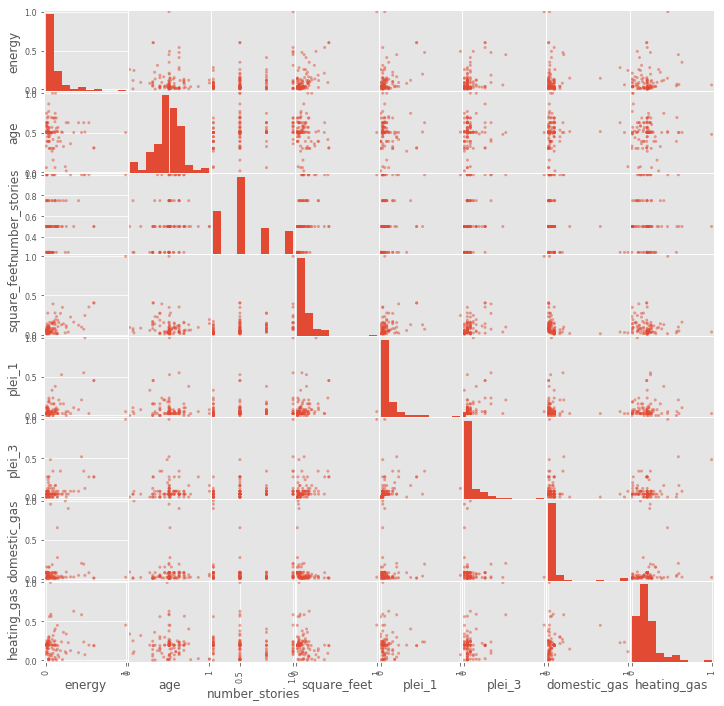

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
ff = pd.tools.plotting.scatter_matrix(dfScaled, diagonal='hist',figsize=(12,12))

<a id="linear_regression"></a>
### Fit a linear regression model to the observed data

Linear regression attempts to model the relationship between two variables by fitting a linear equation to the observed data.
The energy usage (kWh) in buildings can be explained by considering the following building characteristics: 
+ Age of the building 
+ Square feet 
+ Number of stories 
+ Total number of plugged equipment

The regression modeler takes those building characteristics, which you prepared and scaled in an earlier step, and calculates the association between the proposed predicted value and the observed energy usage of the building.

In [13]:
# get a list of the features used to explain energy
features = dfScaled.columns.tolist()
response = ['energy']
features.remove(response[0])
# import regression solver
from sklearn import linear_model
# declare a linear regression model 
lr = linear_model.LinearRegression(fit_intercept=True)
# define response variable: energy usage
y = np.asarray(dfScaled[response]) 
# define features
X = dfScaled[features]
# fit regression model to the data
regr = lr.fit(X,y)
coefs = regr.coef_[0]
# collect regression coefficients
dataRegQ = []
dataRegQ.append(('Intercept', regr.intercept_[0]))
for i in range(len(features)):
    dataRegQ.append((features[i],coefs[i]))
# compute energy predictions using our fitted model     
yh = regr.predict(X)
# import package to compute the R-squared quality metric
from sklearn.metrics import r2_score
# print results
print 'R-Squared: ', r2_score(y,yh)
pd.DataFrame(dataRegQ,columns=['feature_name','coefficient']) #.head()

R-Squared:  0.71750454564


,feature_name,coefficient
0,Intercept,-0.067143
1,age,-0.023500
2,number_stories,0.048774
3,square_feet,0.777122
4,plei_1,0.312308
5,plei_3,0.122954
6,domestic_gas,0.229171
7,heating_gas,0.143661


<a id="visualize_model_accuracy"></a>
### Visualize model accuracy

A scatter plot can be a helpful tool in determining the strength of the relationship between two variables.

Run the following cell to create a scatter plot.

The blue dots represent the observed energy usage versus the energy usage predicted by the trained model. The black dotted line is at 45 degrees and represents the perfect model. The closer the blue dots are to the black dotted line, the better the model fits the data.


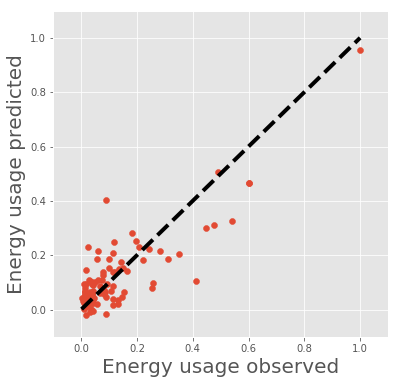

In [14]:
fig, ax = plt.subplots()
ax.scatter(y, yh)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Energy usage observed',fontsize=20)
ax.set_ylabel('Energy usage predicted',fontsize=20)
ax.axis([-0.1, 1.1, -0.1, 1.1])
plt.gcf().set_size_inches( (6, 6) )
plt.show()

<a id="buildings_inefficient"></a>
## Detect buildings that consume energy inefficiently

In this section, you will learn how to use engineered characteristics of heating and cooling systems in buildings to detect those buildings that consume energy inefficiently. Factors that influence high energy consumption include:
+ Air conditioning
+ High usage of plugged-in equipment, for example, microwaves, computers, refrigerators, and freezers
+ Use of gas for domestic usage
+ Use of gas for heating purposes

Run the following cell to prepare the DataFrames to enable detecting and extracting those factors from the data set:

In [15]:
dfCH = dfCH.toPandas()
# get the numerical features
dfR = dfCH[['plug_load_consumption','ac_consumption','domestic_gas','heating_gas']]
# scale features with the max value of each column
dfN = dfR/dfR.max()
# concatenate scaled features and buildings name
dfCH_n = pd.concat((dfN, dfCH['Property Name']),1)

Now run the following cell to only identify the buildings with inefficient air conditioning systems:

In [16]:
cname = 'ac_consumption' #'heating_gas'
dfCH_n[dfCH_n[cname]>dfCH_n.quantile(0.95)[0]][['Property Name',cname]]

,Property Name,ac_consumption
84,CAAABagels,0.997882
86,PaninicoCafeReport,1.000000
87,Curran'sSuperiorMeatsReport,0.717030


<a id="consider_all_metrics"></a>
### Consider all metrics when measuring energy inefficiencies

Up until this point in the notebook, you have used the air conditioning, plugged-in equipment, domestic gas, and heating gas metrics for analytics processing in isolation. By using k-means, you can train your model to consider all of the metrics combined. k-means clustering helps you identify groups of buildings that consume energy inefficiently.  

Run the following cell to import the k-means libraries, prepare the input data set, and define clusters of data in the input data set (groups of buildings) that are similar to one another:


In [17]:
# import K-means and PCA library
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# declare PCA model with 4 components
pca = PCA(n_components=2)
pca.fit(dfN)
featReduced = pca.fit_transform(dfN)
# declare a K-means model with 4 clusters 
kmeans = KMeans(n_clusters=4, tol=0.00001, random_state=1)
# run K-means with our data
kmeans.fit(featReduced)
# get the label for each building using the K-means model
labels = kmeans.predict(featReduced)
buildings = np.asarray(dfCH['Property Name'].values.tolist())

The clustering model helps you to identify inefficient groups of buildings. Visualize the clusters by using two of the four dimensions and the k-means labels to color the observations:

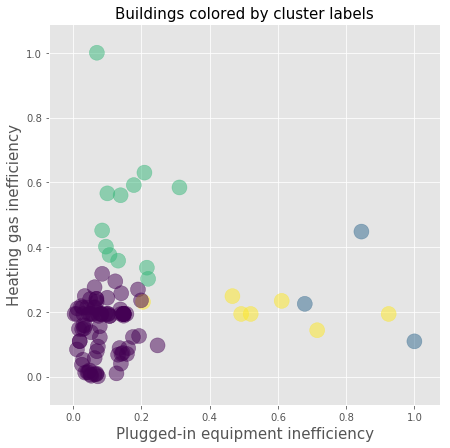

In [18]:
# inefficiency dimensions: ['plug_load_consumption','ac_consumption','domestic_gas','heating_gas']
x = dfCH_n['plug_load_consumption'] 
y = dfCH_n['heating_gas'] 
plt.scatter(x, y, s=225, c=labels, alpha=0.5)
plt.gcf().set_size_inches( (7, 7) )
plt.xlabel('Plugged-in equipment inefficiency',fontsize=15)
plt.ylabel('Heating gas inefficiency',fontsize=15)
tt = 'Buildings colored by cluster labels' 
plt.title(tt,fontsize=15)
plt.show()

The resulting scatter plot shows that most buildings are part of the purple cluster. The buildings with a brown, yellow, or light blue label are more energy inefficient than the ones that are part of the purple cluster.  

Now recode the color labels into a binary variable where 1 is inefficient (the brown, yellow or light blue clusters) and 0 otherwise (the purple cluster):

In [19]:
# define binary variable to identify inefficient buildings
label_binary = []
for v in labels:
    label_binary.append(0 if (v == 0) else 1)
label_binary = np.asarray(label_binary)

Now we split the data into training nd testing:

In [21]:
from sklearn.model_selection import train_test_split
feat_tr, feat_te, lab_tr, lab_te = train_test_split(featReduced, label_binary, train_size=0.8, random_state=1)

Then run the following cell to train a classifier as well as show its accuracy of identifying inefficient buildings:

In [22]:
from sklearn.ensemble import RandomForestClassifier
# declare a random forest model 
rfc = RandomForestClassifier(n_estimators=100)
# fit model with our data
rfc.fit(feat_tr, lab_tr)
# compute accuracy of the trained model
accuracy = rfc.score(feat_te, lab_te)
# compute predictions using trained model
y_pred = rfc.predict(feat_te)
print "Model Accuracy: ", accuracy

Model Accuracy:  0.952380952381


Use a confusion matrix to analyze, summarize, and plot the results of the logistic regression model. A confusion metrix  reports the actual and predicted results of the regression model and thus allows more detailed analysis than calculating the model accuracy based on predictions only.

Run the following cell to define the parameters of the confusion matrix:

In [23]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['efficient','inefficient'], rotation=0)
    plt.yticks(tick_marks, ['efficient','inefficient'])
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

Then create the confusion matrix. In the first row of the confusion matrix, you will notice that the logistic regression model is very good at predicting efficient buildings; however the second row shows that the model is not very accurate at identifying inefficient buildings. The model predicted that only 8 of the 22 buildings were inefficient.

Confusion matrix, without normalization
[[14  1]
 [ 0  6]]


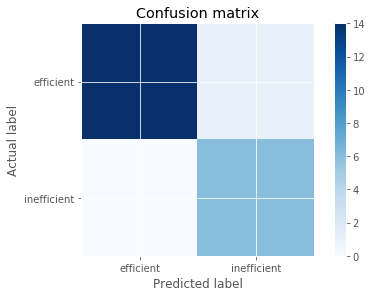

In [24]:
# import confusion matrix to explore model accuracy
from sklearn.metrics import confusion_matrix
# compute confusion matrix
cm = confusion_matrix(lab_te, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

<a id="export_rstudio"></a>
## Export data and models to RStudio

If you want to create an interactive web application (a Shiny app) to visualize and share the results of your data analysis in RStudio, perform the following steps:

1. In Data Science Experience, open RStudio from the left navigation bar.
2. Create a new R Markdown document. You might need to download some R packages.
3. Copy the [raw R code](https://raw.githubusercontent.com/IBMDataScience/SparkSummitDemo/master/shinyDemo.Rmd), and replace the default content in the new R Markdown document by pasting the code into the file.
5. Select lines 21 - 65, and run them to install all necessary packages.
6. Click **Knit**, which is the button with the ball of yarn next to it.
7. Click **Open in Browser** to interact with the app, and share the link with other users.


<a id="summary"></a>
## Summary

In this notebook, you learned how to prepare and cleanse data to use in a linear regression model and how to visualize the accuracy of this model. You learned how to detect building energy inefficiencies by using individual metrics as well as how to use k-means to combine building metrics. You learned the difference between visualizing the results by using a scatter plot and a confusion matrix. In addition, you learned how to create an interactive dashboard in RStudio to interact with and share analysis results. 

### Author
**Jorge Castañón** is a data scientist at IBM Analytics, specializing in machine learning and text analytics using Apache Spark and Hadoop.

<div class="alert alert-block alert-info"> Note: To save resources and get the best performance please use the code below to stop the kernel before exiting your notebook.</div>

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<hr>
Copyright &copy; IBM Corp. 2017. Released as licensed Sample Materials.